# Hands-on Machine Learning - (ML) Lab

# sentence-classification-with-electra

## Load data and model

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# only used in colab case
from google.colab import files
uploaded = files.upload()

Saving test_20k.txt to test_20k.txt


In [5]:
!pip install transformers datasets

     |████████████████████████████████| 2.6 MB 4.2 MB/s 
     |████████████████████████████████| 264 kB 29.2 MB/s 
     |████████████████████████████████| 636 kB 40.4 MB/s 
     |████████████████████████████████| 3.3 MB 37.0 MB/s 
     |████████████████████████████████| 895 kB 40.0 MB/s 
     |████████████████████████████████| 118 kB 48.6 MB/s 
     |████████████████████████████████| 76 kB 4.1 MB/s 
     |████████████████████████████████| 243 kB 38.2 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
def preprocessing(filename):
    with open(filename, "r") as f:
        Input = f.readlines() 
        Abs_lines = "" 
        Abs_samples = []
        for line in Input:
            if line.startswith("###"):
                ID = line
                Abs_lines = "" 
            elif line.isspace(): 
                Abs_line_split = Abs_lines.splitlines()
                for Abs_line_number, Abs_line in enumerate(Abs_line_split):
                    line_data = {} 
                    part_text_split = Abs_line.split("\t") 
                    line_data["labels"] = part_text_split[0]
                    line_data["TEXT"] = part_text_split[1].lower() 
                    #line_data["line_number"] = Abs_line_number 
                    #line_data["total_numb_lines"] = len(Abs_line_split) - 1 
                    Abs_samples.append(line_data) 
            else:
                Abs_lines += line
    return Abs_samples

In [27]:
train = preprocessing(PubMed_20k_train)
Train_dframe = pd.DataFrame(train)
Train_dframe['labels'].replace('BACKGROUND',0, inplace = True)
Train_dframe['labels'].replace('OBJECTIVE',1, inplace = True)
Train_dframe['labels'].replace('METHODS',2, inplace = True)
Train_dframe['labels'].replace('CONCLUSIONS',3, inplace = True)
Train_dframe['labels'].replace('RESULTS',4, inplace = True)
Train_dframe

,labels,TEXT
0,1,to investigate the efficacy of 6 weeks of dail...
1,2,a total of 125 patients with primary knee oa w...
2,2,outcome measures included pain reduction and i...
3,2,pain was assessed using the visual analog pain...
4,2,secondary outcome measures included the wester...
...,...,...
180035,4,for the absolute change in percent atheroma vo...
180036,4,"for pav , a significantly greater percentage o..."
180037,4,both strategies had acceptable side effect pro...
180038,3,"compared with standard statin monotherapy , th..."


In [28]:
test = preprocessing(PubMed_20k_test)
Test_dframe = pd.DataFrame(test)
Test_dframe['labels'].replace('BACKGROUND',0, inplace = True)
Test_dframe['labels'].replace('OBJECTIVE',1, inplace = True)
Test_dframe['labels'].replace('METHODS',2, inplace = True)
Test_dframe['labels'].replace('CONCLUSIONS',3, inplace = True)
Test_dframe['labels'].replace('RESULTS',4, inplace = True)
Test_dframe

,labels,TEXT
0,0,this study analyzed liver function abnormaliti...
1,4,a post hoc analysis was conducted with the use...
2,4,liver function tests ( lfts ) were measured at...
3,4,survival analyses were used to assess the asso...
4,4,the percentage of patients with abnormal lfts ...
...,...,...
30130,4,there was a statistically significant between-...
30131,4,there were no statistically significant betwee...
30132,4,there was no significant association between s...
30133,4,no adverse effects were reported .


In [29]:
from datasets import Dataset
dataset_train = Dataset.from_pandas(Train_dframe)
dataset_train

Dataset({
    features: ['labels', 'TEXT'],
    num_rows: 180040
})

In [30]:
dataset_test = Dataset.from_pandas(Test_dframe)
dataset_test

Dataset({
    features: ['labels', 'TEXT'],
    num_rows: 30135
})

## load model

In [11]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification
tokenizer = ElectraTokenizer.from_pretrained("molly-hayward/bioelectra-small-generator")
model = ElectraForSequenceClassification.from_pretrained('molly-hayward/bioelectra-small-generator', num_labels = 5)

Downloading:   0%|          | 0.00/239k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/453 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/731 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/18.4M [00:00<?, ?B/s]

Some weights of the model checkpoint at molly-hayward/bioelectra-small-generator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at molly-hayward/bioelectra-small-generator and are newly initialized: 

In [32]:
dataset_train = dataset_train.map(lambda x: tokenizer(x['TEXT'].strip(), max_length=128, truncation=True, padding="max_length"))

  0%|          | 0/180040 [00:00<?, ?ex/s]

In [33]:
# Transform to pytorch tensors and only output the required columns
dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [34]:
dataset_test = dataset_test.map(lambda x: tokenizer(x['TEXT'].strip(), max_length=128, truncation=True, padding="max_length"))

  0%|          | 0/30135 [00:00<?, ?ex/s]

In [35]:
dataset_test.set_format(type="torch", columns=["input_ids","attention_mask", "labels"])

In [36]:
dataset_train

Dataset({
    features: ['labels', 'TEXT', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 180040
})

## Train the model

In [17]:
from transformers import Trainer, TrainingArguments, EvalPrediction
import numpy as np

In [37]:
# checking the paper:
argument = TrainingArguments(output_dir = '/Users/wangdanqi/Desktop/dir.txt', do_train = True, do_eval = False, learning_rate = 5e-4, num_train_epochs=10, per_device_train_batch_size=128, per_device_eval_batch_size=128, remove_unused_columns=False)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [38]:
def compute_accuracy(p:EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return {"acc": (preds == p.label_ids).mean()}

In [39]:
trainer = Trainer(model = model, args = argument, train_dataset = dataset_train, eval_dataset = dataset_test, tokenizer = tokenizer, compute_metrics = compute_accuracy)

In [40]:
trainer.train()

***** Running training *****
  Num examples = 180040
  Num Epochs = 10
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 14070


Step,Training Loss
500,0.439800
1000,0.442100
1500,0.437900
2000,0.396600
2500,0.392600
3000,0.374200
3500,0.350300
4000,0.358100
4500,0.338900
5000,0.321700


Saving model checkpoint to /Users/wangdanqi/Desktop/dir.txt/checkpoint-500
Configuration saved in /Users/wangdanqi/Desktop/dir.txt/checkpoint-500/config.json
Model weights saved in /Users/wangdanqi/Desktop/dir.txt/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /Users/wangdanqi/Desktop/dir.txt/checkpoint-500/tokenizer_config.json
Special tokens file saved in /Users/wangdanqi/Desktop/dir.txt/checkpoint-500/special_tokens_map.json
Saving model checkpoint to /Users/wangdanqi/Desktop/dir.txt/checkpoint-1000
Configuration saved in /Users/wangdanqi/Desktop/dir.txt/checkpoint-1000/config.json
Model weights saved in /Users/wangdanqi/Desktop/dir.txt/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in /Users/wangdanqi/Desktop/dir.txt/checkpoint-1000/tokenizer_config.json
Special tokens file saved in /Users/wangdanqi/Desktop/dir.txt/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to /Users/wangdanqi/Desktop/dir.txt/checkpoint-1500
Configuration saved i

TrainOutput(global_step=14070, training_loss=0.29183637284181946, metrics={'train_runtime': 4144.3715, 'train_samples_per_second': 434.421, 'train_steps_per_second': 3.395, 'total_flos': 847329885696000.0, 'train_loss': 0.29183637284181946, 'epoch': 10.0})

## Evaluate the model

In [41]:
# run evaluation
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 30135
  Batch size = 128


{'epoch': 10.0,
 'eval_acc': 0.839522150323544,
 'eval_loss': 0.5631722211837769,
 'eval_runtime': 29.8367,
 'eval_samples_per_second': 1009.996,
 'eval_steps_per_second': 7.91}

In [50]:
# predict on test set
prediction = trainer.predict(dataset_test)

***** Running Prediction *****
  Num examples = 30135
  Batch size = 128


### Calculate the average and class-wise F1 scores

In [65]:
from sklearn.metrics import classification_report

y_true = dataset_test['labels']
# get y_pred data:
pre = np.array(prediction)
data = pre[0]
n, m = np.shape(data)
y_pred = []

for i in range(n):
    for j in range(m):
        if data[i,j] == max(data[i,:]):
        y_pred.append(j)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [66]:
target_names = ['BACKGROUND', 'OBJECTIVE', 'METHODS', 'CONCLUSIONS', 'RESULTS']
print(classification_report(y_true, y_pred, target_names=target_names))


              precision    recall  f1-score   support

  BACKGROUND       0.65      0.69      0.67      3621
   OBJECTIVE       0.65      0.59      0.62      2333
     METHODS       0.91      0.93      0.92      9897
 CONCLUSIONS       0.78      0.79      0.79      4571
     RESULTS       0.91      0.89      0.90      9713

    accuracy                           0.84     30135
   macro avg       0.78      0.78      0.78     30135
weighted avg       0.84      0.84      0.84     30135



## Make a new prediction using our model

In [43]:
from transformers import TextClassificationPipeline

classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=argument.device.index)

classifier("This result looks good!")

[{'label': 'LABEL_3', 'score': 0.7144426107406616}]

# Visualization of scores

In [68]:
from sklearn.metrics import precision_recall_fscore_support as score
precision,recall,fscore,support=score(y_true, y_pred)

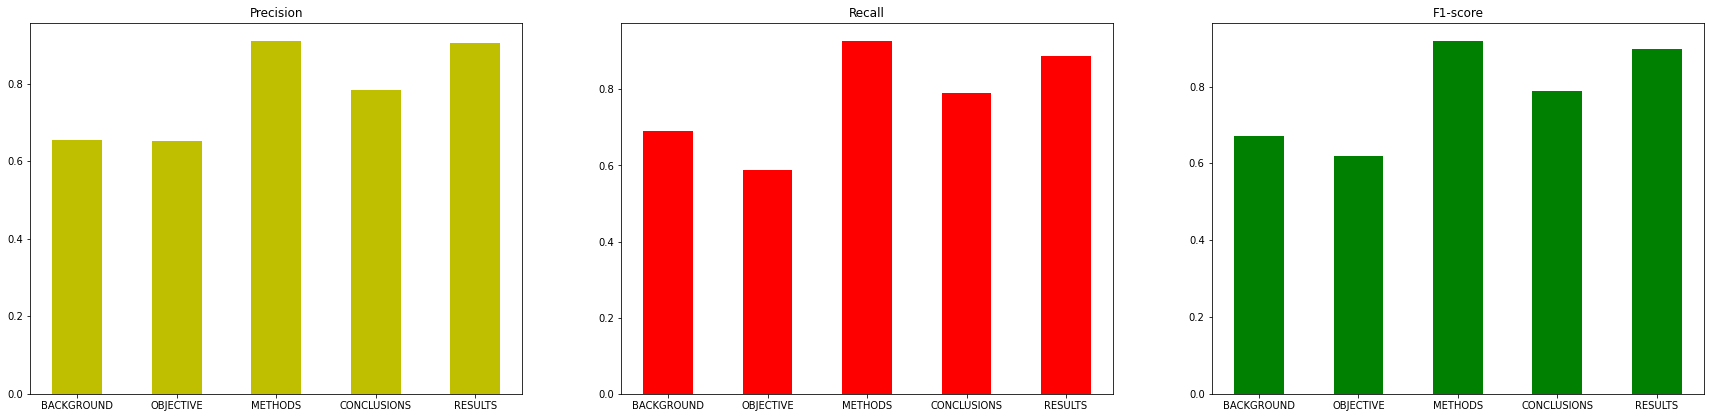

In [73]:
import matplotlib.pyplot as plt
x = np.arange(len(target_names)) 
width = 0.5 

plt.figure(figsize=(30,15))

plt.subplot(231)
plt.title('Precision')
plt.bar(x-width , precision, width, tick_label = target_names,fc = 'y')

plt.subplot(232)
plt.title('Recall')
plt.bar(x-width, recall, width, tick_label = target_names,fc = 'r')

plt.subplot(233)
plt.title('F1-score')
plt.bar(x - width, fscore, width, tick_label = target_names,fc = 'g')
plt.show()

## Comparison of different algorithms

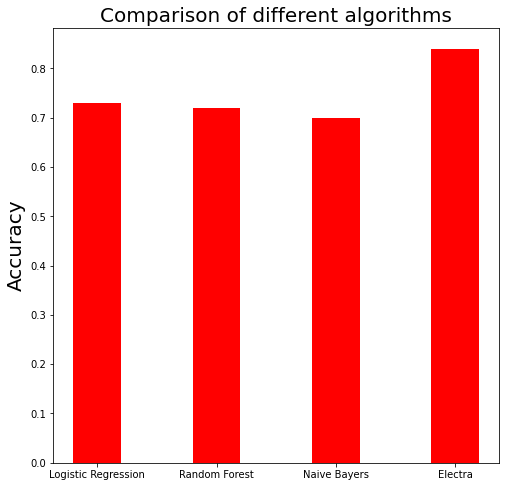

In [99]:
list_names = ['Logistic Regression', 'Random Forest', 'Naive Bayers', 'Electra']
x = [1, 2, 3, 4]
y = [0.73, 0.72, 0.70, 0.84]

plt.figure(figsize=(8,8))
width = 0.4
plt.title('Comparison of different algorithms', fontsize = 20)

plt.ylabel('Accuracy',fontsize = 20)

plt.bar(x, y, width,fc='r', tick_label = list_names)
plt.show()



## Conclusion

1. Our ELECTRA model has accuracy of 0.84.
2. Among all classes, Methods and Results can be classfied well (highest precision, F1 score and Recall).
3. Compared with other algorithms, ELECTRA performs best.